# Non-Newtonian Rheology

> [Return to Examples List](README.md)

This notebook demonstrates how to quantify the flow behaviour of a non-Newtonian fluid (mayonnaise) using a fit to the Herschel-Bulkley model.

## Load Experiment Data

First, let's load the experiment data from a JSON file and convert it into a Pandas DataFrame.

In [1]:
# This is just to ensure you have the data file, downloaded from TA's website
from file_downloader import download_files

filename = "HR - Mayo.json"
file_path = download_files(filename, "files")[0]

In [2]:
from tadatakit.classes import Experiment

# Load the experiment data
experiment = Experiment.from_json(file_path)
df = experiment.get_dataframes_by_step("processed")[1][1]

## Plotting The Data

Next, we can plot the shear stress against shear rate.

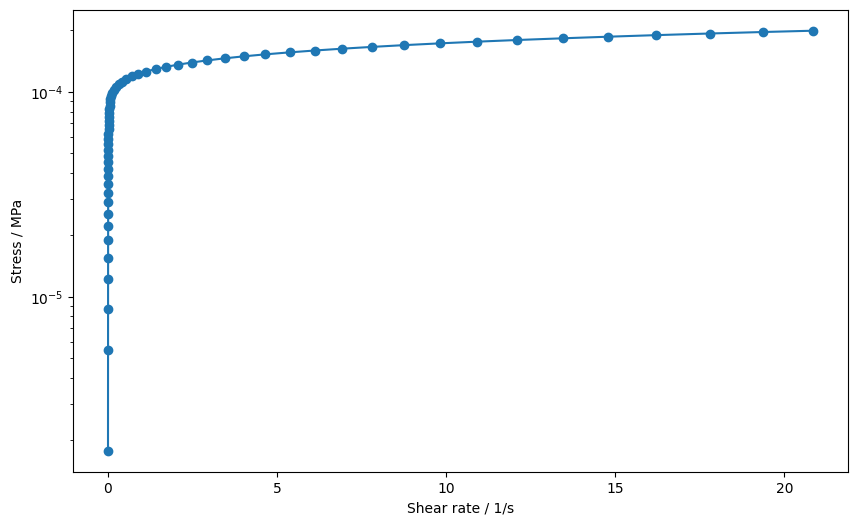

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.semilogy(
    df["Shear rate / 1/s"],
    df["Stress / MPa"],
    marker='o'
)

plt.xlabel("Shear rate / 1/s")
plt.ylabel("Stress / MPa")
plt.show()

## Implementing Herschel-Bulkley Model

We implement a simple gradient descent function and the Herschel-Bulkley model, which is of the following form.

$$\tau = \tau_0 + K \dot{\gamma}^n $$

where:
- $\tau$ is the shear stress.
- $\tau_0$ is the yield stress (the stress required to initiate flow).
- $K$ is the consistency index (a measure of the fluid's viscosity).
- $\dot{\gamma}$ is the shear rate.
- $n$ is the flow behavior index (indicating the degree of shear-thinning or shear-thickening behavior).

In [4]:
import numpy as np

def gradient_descent(f, initial_params, learning_rate=0.01, tolerance=1e-8, max_iterations=10000):
    """
    Perform gradient descent to minimize a given function.

    Args:
        f (callable): The objective function to minimize. It should take a single argument 
                      (the parameters) and return a scalar value.
        initial_params (array-like): Initial guess for the parameters.
        learning_rate (float, optional): The learning rate or step size for the gradient
                                         descent updates. Default is 0.001.
        tolerance (float, optional): The convergence tolerance. If the norm of the parameter
                                     update is less than this value, the algorithm will stop.
                                     Default is 1e-6.
        max_iterations (int, optional): The maximum number of iterations to perform. Default
                                        is 1000.

    Returns:
        numpy.ndarray: The optimized parameters that minimize the objective function.
    """
    params = np.array(initial_params)
    for i in range(max_iterations):
        current_value = f(params)
        gradients = np.zeros_like(params)
        for j in range(len(params)):
            params_step = params.copy()
            params_step[j] += tolerance
            gradients[j] = (f(params_step) - current_value) / tolerance
        new_params = params - learning_rate * gradients
        if np.linalg.norm(new_params - params) < tolerance:
            break
        params = new_params
    return params

def herschel_bulkley_model(shear_rates, tau_0, K, n):
    """
    Calculate shear stresses using the Herschel-Bulkley model.

    Parameters:
    shear_rates (array-like): Series of shear rates (γ̇).
    tau_0 (float): Yield stress (τ₀).
    K (float): Consistency index.
    n (float): Flow behavior index.

    Returns:
    numpy.ndarray: Series of shear stresses (τ).
    """
    shear_rates = np.array(shear_rates)
    shear_stresses = tau_0 + K * shear_rates**n
    return shear_stresses

## Fitting the Model

Now we can select a subset of the data, where shear stress is greater than 40% of the maximum shear stress, and fit the model. Finally, we can print and plot the results.

Yield Stress: 48.7 Pa
Consistency Index: 74.8 Pa.s
Flow Behaviour Index: 0.22
Mayonnaise is a shear-thinning fluid!


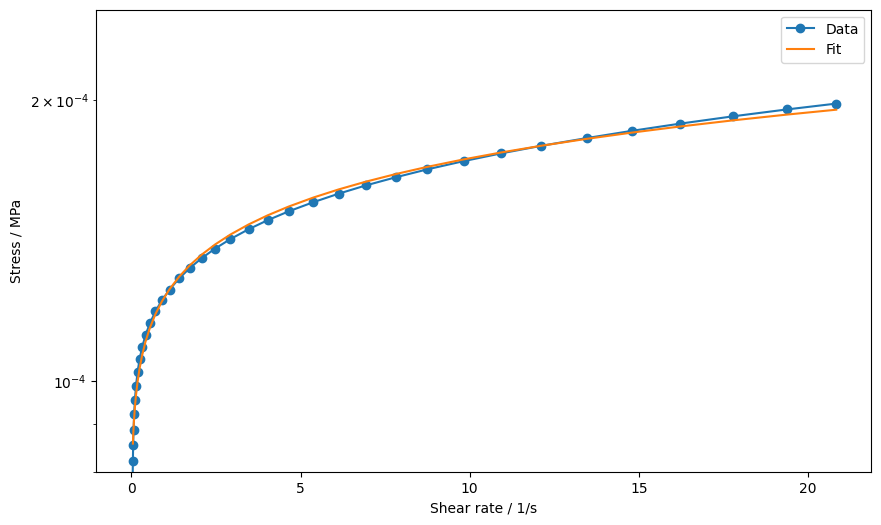

In [5]:
subset_df = df[(df["Stress / MPa"] / df["Stress / MPa"].max()) > 0.4]

n_factor = 1e3

def herschel_bulkley_fitting_function(params):
    tau_0, K, n = params
    shear_stresses = herschel_bulkley_model(subset_df["Shear rate / 1/s"], tau_0, K, n * n_factor)
    return np.sum(np.square(shear_stresses - subset_df["Stress / MPa"]))

# Initial parameter values
initial_params = [1e-7, 1e-4, 0.2 / n_factor]

# Fit the model using gradient descent
tau_0, K, n = gradient_descent(herschel_bulkley_fitting_function, initial_params)
n = n * n_factor

# Print optimized parameters
print(f"Yield Stress: {tau_0*1e6:.1f} Pa\nConsistency Index: {K*1e6:.1f} Pa.s\nFlow Behaviour Index: {n:.2f}")
if n < 1:
    print("Mayonnaise is a shear-thinning fluid!")
elif n > 1:
    print("Mayonnaise is a shear-thickening fluid!")

fig = plt.figure(figsize=(10,6))
plt.semilogy(
    df["Shear rate / 1/s"],
    df["Stress / MPa"],
    marker='o',
    label="Data"
)

subset_df = df[(df["Stress / MPa"] / df["Stress / MPa"].max()) > 0.4]
plt.semilogy(
    subset_df["Shear rate / 1/s"],
    herschel_bulkley_model(subset_df["Shear rate / 1/s"], tau_0, K, n),
    label="Fit"
)

plt.ylim(8e-5, 2.5e-4)
plt.legend()
plt.xlabel("Shear rate / 1/s")
plt.ylabel("Stress / MPa")
plt.show()